In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import gprofiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         8.4.0
anndata2ri                  1.0.6
appnope                     0.1.2
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.2
certifi                     2021.10.08
cffi                        1.15.0
charset_normalizer          2.0.7
cloudpickle                 2.0.0
cycler                      0.10.0
cython_runtime              NA
cytoolz  

In [6]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")


In [20]:
%%R
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

In [47]:
data_file = "/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/data_folder/my_data/GSM4567140_PJ069.matrix.txt"
matrix = pd.read_csv(data_file, delimiter="\t")
#drop 1 column with nan
matrix = matrix.dropna(axis="columns")
#convert to numpy array
sparse_matrix = matrix.iloc[:, 2:]
sparse_matrix = sparse_matrix.to_numpy()
#save sparse_matrix as csv
pd.DataFrame(sparse_matrix).to_csv("/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/data_folder/my_data/GSM4567140_PJ069_matrix.csv", header=None, index=None)

In [57]:
data_file = "/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/data_folder/my_data/GSM4567140_PJ069.matrix.txt"
matrix = pd.read_csv(data_file, delimiter="\t")
#drop 1 column with nan
matrix = matrix.dropna(axis="columns")

genes = matrix.iloc[:, 0:2]
pd.DataFrame(genes).to_csv("/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/data_folder/my_data/GSM4567140_PJ069_genes.csv", header=None, index=None)

In [58]:
data_file = "/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/data_folder/my_data/GSM4567140_PJ069.matrix.txt"
matrix = pd.read_csv(data_file, delimiter="\t")
#drop 1 column with nan
matrix = matrix.dropna(axis="columns")

barcodes = matrix.iloc[:, 2:].columns.values
barcodes.transpose()
pd.DataFrame(barcodes).to_csv("/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/data_folder/my_data/GSM4567140_PJ069_barcodes.csv", header=None, index=None)

In [76]:
matrix = "/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/data_folder/my_data/GSM4567140_PJ069_matrix.csv"
barcode_file = "/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/data_folder/my_data/GSM4567140_PJ069_barcodes.csv"
gene_file = "/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/data_folder/my_data/GSM4567140_PJ069_genes.csv"

#Load data
#this is in the format genes x cells
#scanpy expects cells x genes and so must transpose
adata = sc.read(matrix, cache=True)
adata = adata.transpose()

barcodes = pd.read_csv(barcode_file, header=None)
genes = pd.read_csv(gene_file, header=None)

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes

genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)

genes.set_index('gene_symbol', inplace=True)

adata.var = genes
print(adata.var) #this looks the same as the tutorial



... reading from cache file cache/Users-esthomas-Andor_Rotation-github_repo-cross-modal-autoencoders-data_folder-my_data-GSM4567140_PJ069_matrix.h5ad
                          gene_id
gene_symbol                      
IL36A           ENSG00000136694.8
TRAV1-1         ENSG00000255569.1
LARP1BP1        ENSG00000231442.3
ATP13A5-AS1     ENSG00000236508.1
NKAIN2         ENSG00000188580.13
...                           ...
BX682235.1      ENSG00000234404.2
RNA5SP508       ENSG00000223259.1
HSPA8P1         ENSG00000234176.1
PPP2R2DP1       ENSG00000231668.2
RP11-718B12.1   ENSG00000255063.1

[60725 rows x 1 columns]


In [82]:
print(adata.var_names)
adata.var_names_make_unique()
print(adata.var_names)

Index(['IL36A', 'TRAV1-1', 'LARP1BP1', 'ATP13A5-AS1', 'NKAIN2', 'Metazoa_SRP',
       'HMGB1P44', 'OR5W1P', 'RFPL2', 'RNU6-938P',
       ...
       'SOWAHA', 'SSU72P8', 'AC055811.1', 'C17orf104', 'LINC00917',
       'BX682235.1', 'RNA5SP508', 'HSPA8P1', 'PPP2R2DP1', 'RP11-718B12.1'],
      dtype='object', name='gene_symbol', length=60725)
Index(['IL36A', 'TRAV1-1', 'LARP1BP1', 'ATP13A5-AS1', 'NKAIN2', 'Metazoa_SRP',
       'HMGB1P44', 'OR5W1P', 'RFPL2', 'RNU6-938P',
       ...
       'SOWAHA', 'SSU72P8', 'AC055811.1', 'C17orf104', 'LINC00917',
       'BX682235.1', 'RNA5SP508', 'HSPA8P1', 'PPP2R2DP1', 'RP11-718B12.1'],
      dtype='object', name='gene_symbol', length=60725)


In [83]:
#check for duplicate var names
from collections import Counter
[k for k,v in Counter(adata.var_names).items() if v>1]

[]

In [94]:
#counts per transcript
print(len(adata.X.sum(1)))
print(adata.X.sum(1))

print(len((adata.X > 0).sum(1)))
print((adata.X > 0).sum(1))



1954
[27100. 15237. 13244. ...  1005.  1002.  1001.]
1954
[7450 5489 5000 ...  753  730  699]


In [84]:
# Quality control - calculate QC covariates
# number of molecule counts (UMIs)
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

# MT- prefix for mitochondria
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

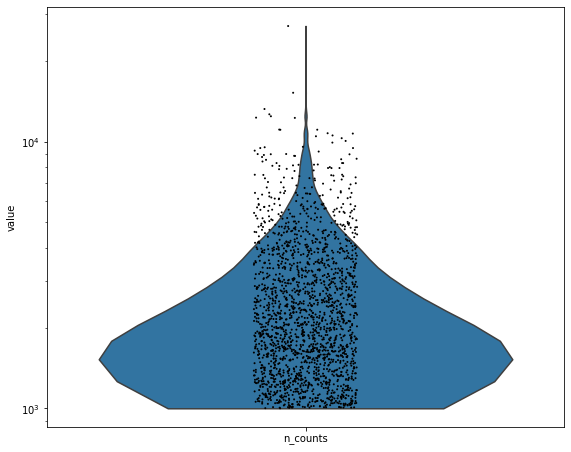

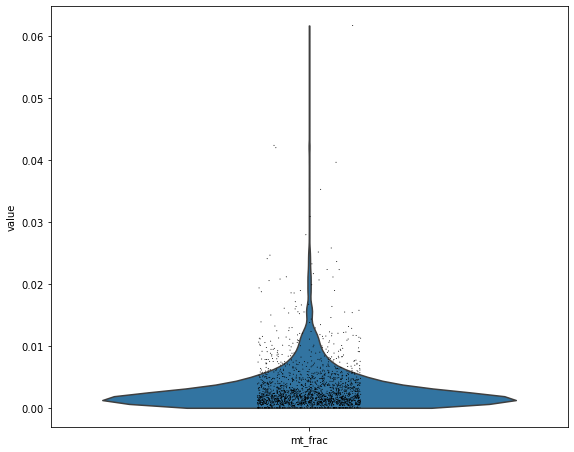

In [85]:
#Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac')

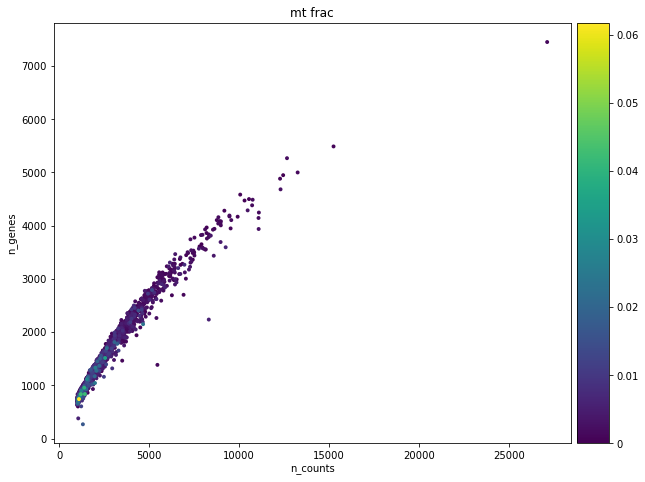

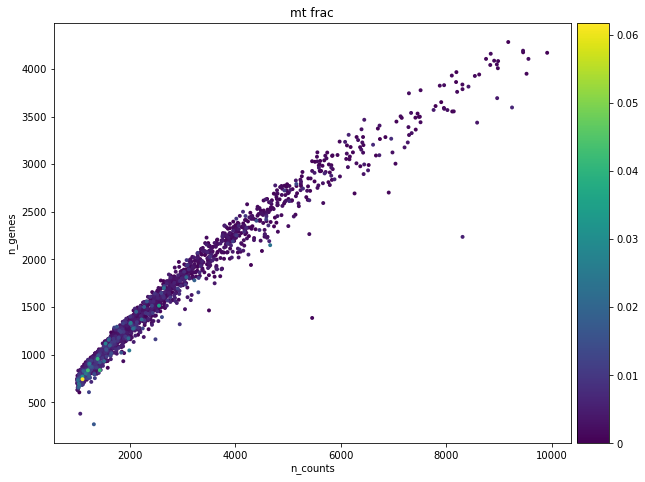

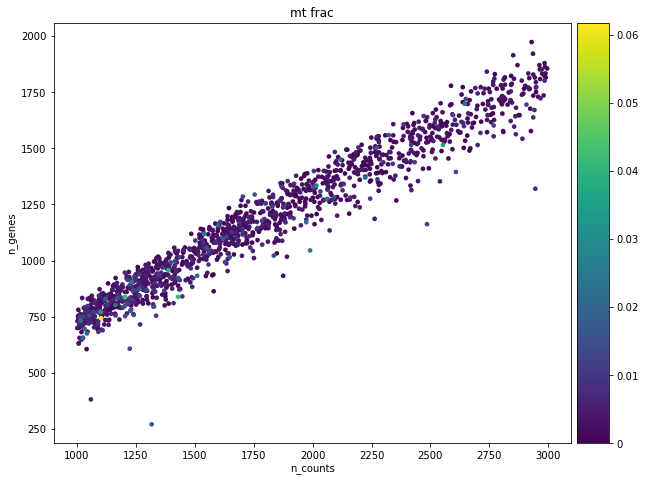

In [98]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')
p22 = sc.pl.scatter(adata[adata.obs['n_counts']<3000], 'n_counts', 'n_genes', color='mt_frac')


/Users/esthomas/opt/anaconda3/envs/auto_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


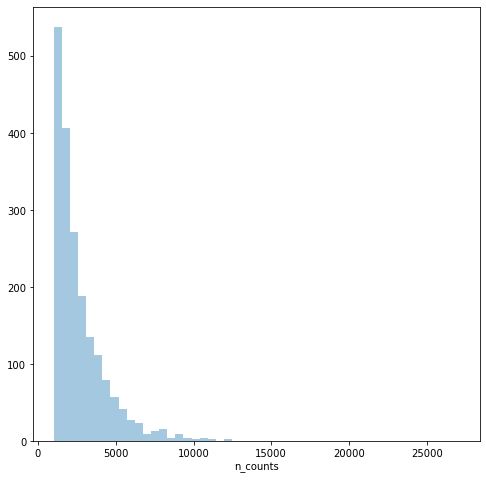

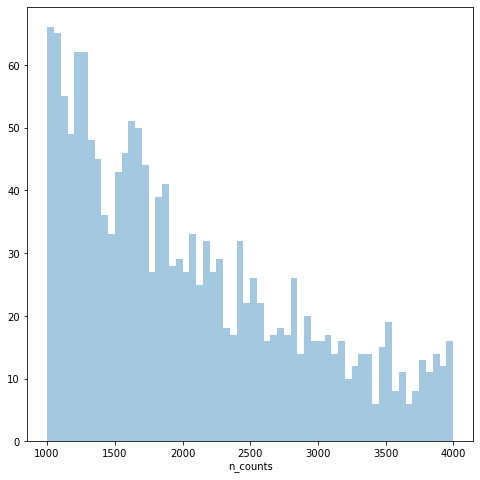

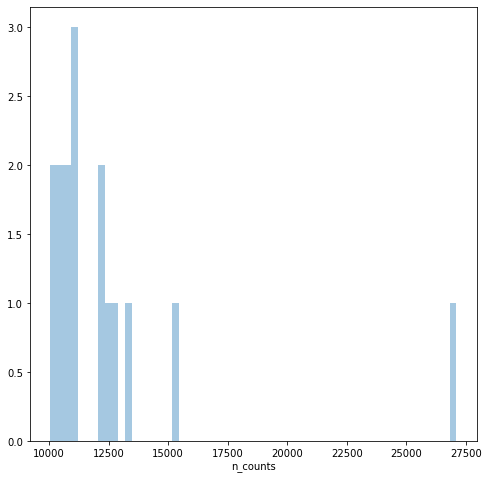

In [96]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
plt.show()

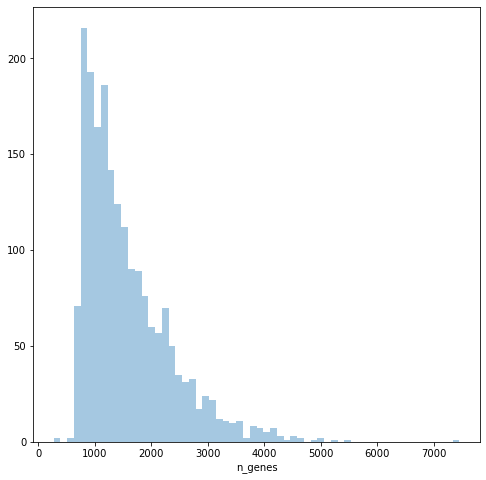

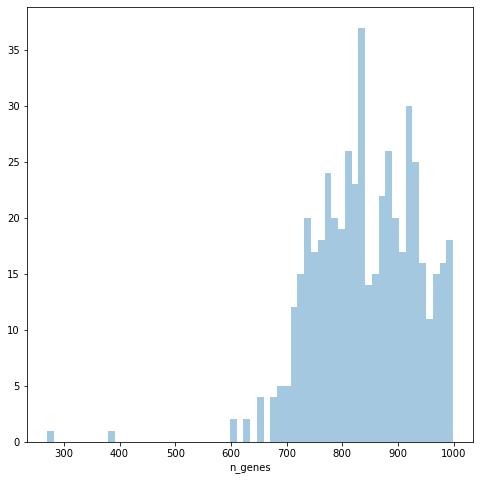

In [97]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

In [99]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

#I'm not going to do a minimum count filter - because even tho there is higher mt in gene vs count plot it's still 0.06
'''
sc.pp.filter_cells(adata, min_counts = 1500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))
'''

sc.pp.filter_cells(adata, max_counts = 20000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 1954
filtered out 1 cells that have more than 20000 counts
Number of cells after max count filter: 1953
Number of cells after MT filter: 1953
filtered out 20 cells that have less than 700 genes expressed


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 1933


In [100]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 60725
filtered out 44911 genes that are detected in less than 20 cells
Number of genes after cell filter: 15814


In [101]:
#now I want to convert my filtered adata to a csv to work with

print(adata.X.shape)

#my data is in cells x genes but i want it in genes x cells so going to have to transpose it

(1933, 15814)


In [102]:
adata.write_csvs("example_adata.csv", skip_data=False)

writing .csv files to example_adata


In [103]:
#gonna try the transpose now 
adata.transpose().write_csvs("example_adata_transpose.csv", skip_data=False)
#transpose looks good 

writing .csv files to example_adata_transpose


In [130]:
#going to write it to a full csv in the form of the uhler filtered_lognuminorm_pc_rp_7633genes_1396cellsnCD4 form
X = "/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/example_adata_transpose/X.csv"
barcodes = "/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/example_adata_transpose/var.csv"
genes = "/Users/esthomas/Andor_Rotation/github_repo/cross-modal-autoencoders/example_adata_transpose/obs.csv"
data = pd.read_csv(X, header=None)
samples = pd.read_csv(barcodes)
gene = pd.read_csv(genes)


       0     1     2     3     4     5     6     7     8     9     ...  1923  \
0       0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1       1.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2       2.0   1.0   0.0   0.0   2.0   0.0   0.0   0.0   3.0   0.0  ...   0.0   
3       1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4       0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0  ...   0.0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
15809   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  ...   0.0   
15810   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
15811   0.0   6.0   4.0   1.0   1.0   2.0   4.0   4.0  13.0   0.0  ...   2.0   
15812   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
15813   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

       1924  1925  1926  1927  1928  19

In [131]:
print(gene.shape)
print(data.shape)
print(samples.shape)

(15814, 3)
(15814, 1933)
(1933, 5)


In [132]:
print(gene.iloc[:, 0])

0           HMGB1P44
1              RBBP9
2        RP11-6K23.1
3            THUMPD3
4              RAB15
            ...     
15809          CLHC1
15810          PHBP7
15811          HLA-J
15812           TOM1
15813        HSPA8P1
Name: gene_symbol, Length: 15814, dtype: object


In [138]:
data.columns = samples.iloc[:, 0] 
data.index = gene.iloc[:, 0]

In [140]:
pd.DataFrame(data).to_csv('my_data.csv')